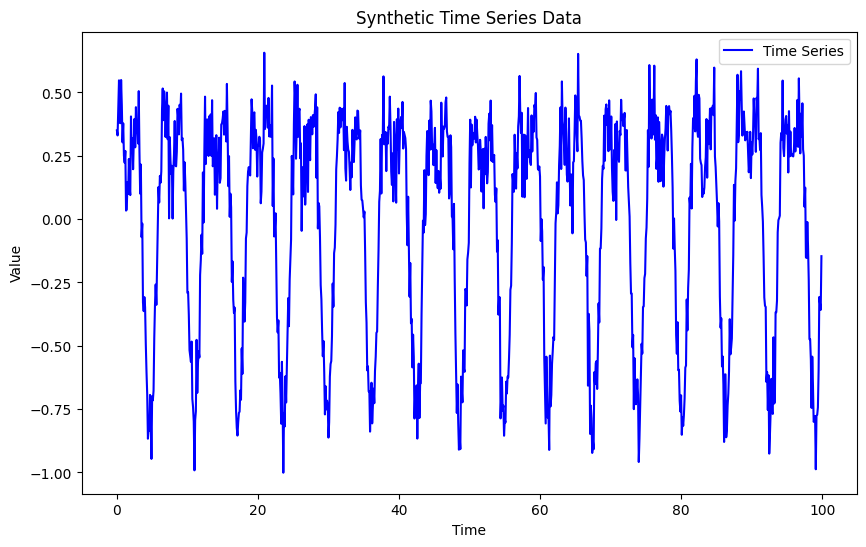

In [1]:
# 参考自 https://mp.weixin.qq.com/s/VoedSVDV_uqVQRGXewMf8A
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 创建虚拟时间序列数据
np.random.seed(42)
time = np.arange(0, 100, 0.1)
series = 0.5 * np.sin(time) + 0.3 * np.cos(2 * time) + 0.1 * np.random.randn(len(time))

# 可视化数据
plt.figure(figsize=(10, 6))
plt.plot(time, series, label="Time Series", color="blue")
plt.title("Synthetic Time Series Data")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()


# 转化为训练数据
def create_dataset(series, look_back):
    X, y = [], []
    for i in range(len(series) - look_back):
        X.append(series[i : i + look_back])
        y.append(series[i + look_back])
    return np.array(X), np.array(y)


look_back = 20
X, y = create_dataset(series, look_back)


In [ ]:
# Transformer 模型 PyTorch 实现
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset


# 定义 Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        return x + self.pe[:, : x.size(1), :]


# 定义 Transformer 模型
class TransformerModel(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, output_dim):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, model_dim)
        self.pos_encoder = PositionalEncoding(model_dim)
        self.transformer = nn.Transformer(
            d_model=model_dim, nhead=num_heads, num_encoder_layers=num_layers
        )
        self.fc_out = nn.Linear(model_dim, output_dim)

    def forward(self, src):
        src = self.embedding(src)
        src = self.pos_encoder(src)
        output = self.transformer(src, src)
        return self.fc_out(output[:, -1, :])


# 数据加载
batch_size = 64
X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # (samples, look_back, 1)
y_tensor = torch.tensor(y, dtype=torch.float32)
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 初始化模型
model = TransformerModel(
    input_dim=1, model_dim=64, num_heads=4, num_layers=2, output_dim=1
)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# 模型训练
epochs = 20
losses = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    losses.append(epoch_loss / len(dataloader))
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(dataloader):.4f}")

In [ ]:
# 训练损失趋势图
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), losses, marker="o", color="green")
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [ ]:
# 预测与真实值对比
model.eval()
with torch.no_grad():
    test_pred = model(X_tensor).squeeze().numpy()

plt.figure(figsize=(10, 6))
plt.plot(range(len(y)), y, label='True Values', color='blue')
plt.plot(range(len(test_pred)), test_pred, label='Predictions', color='red')
plt.title('Model Predictions vs True Values')
plt.xlabel('Time Index')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
# 误差分布图
errors = y - test_pred
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=20, color="purple", alpha=0.7)
plt.title("Prediction Errors Distribution")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.grid()
plt.show()

In [3]:
import lightning as L


class LitQuickLLM(L.LightningModule):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def training_step(self, batch, batch_idx):
        x, _ = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = nn.functional.mse_loss(x_hat, x)
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


# model
quick_llm_model = LitQuickLLM()

# train model
# trainer = L.Trainer()
# trainer.fit(model=quick_llm_model, train_dataloaders=train_loader)



AttributeError: partially initialized module 'lightning.pytorch' has no attribute 'accelerators' (most likely due to a circular import)